In [1]:
%autosave 60

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import math

#For the sake of reconstruction with exact same behavior
RANDOM_SEED = 1234
TORCH_SEED = 4556
np.random.seed(RANDOM_SEED)
torch.manual_seed(TORCH_SEED)

Autosaving every 60 seconds


# 1. Data Processing Pipleline

Given data in xlsx/csv/json format

Convert to numpy array X, y


Final Input: X (num_samples, num_features)

Final Output: y (num_samples, 1)

## 1.1 Load Data as Tensors

In [2]:
INPUT_DATA_DIR = "C:/Users/MSI/Google Drive/Research/PyTorch Practice/pytorchTutorial-master/data/wine/"
INPUT_DATA_FILE = "wine.csv"

class MyDataset(Dataset):
    
    def __init__(self):
        #Read from CSV file, ref: https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html
        XY = np.genfromtxt(INPUT_DATA_DIR+INPUT_DATA_FILE, delimiter=',', skip_header=1)
        self.n_samples = XY.shape[0]
        self.X = XY[:,1:]
        #multi-class, y in [1,3] -> [0,2]
        self.y = XY[:,0]-1.0
        
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return (self.X[index], self.y[index])
    
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
dataset = MyDataset()

## 1.2 Train, Test, Dev Split

In [4]:
TRAIN_TEST_DEV_SPLIT = [0.7, 0.15, 0.15]

N = len(dataset)
n_train = (int)(TRAIN_TEST_DEV_SPLIT[0]*N)
n_test = (int) (TRAIN_TEST_DEV_SPLIT[1]*N)
n_dev = N - n_train - n_test

train_dataset, test_dataset, dev_dataset = torch.utils.data.random_split(dataset, [n_train, n_test, n_dev])

# 2. Model Definition

Start with exploring training data shapes

In [5]:
num_samples, num_features = len(train_dataset), train_dataset[0][0].shape[0]

input_size = num_features
output_size = 3

print(f"Input size {input_size}, Output size {output_size}")

Input size 13, Output size 3


In [6]:
class CustomModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomModel, self).__init__()
        hidden_dims = [10, 15, 10]
        
        # define diferent layers
        self.first_linear = nn.Linear(input_dim, hidden_dims[0])
        self.first_activation = nn.Sigmoid()
        self.second_linear = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.second_activation = nn.Sigmoid()
        self.third_linear = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.third_activation = nn.Sigmoid()
        self.fourth_linear = nn.Linear(hidden_dims[2], output_dim)
        self.fourth_activation = nn.Softmax(dim=1)
        
    def forward(self, x):
        z1 = self.first_linear(x)
        a1 = self.first_activation(z1)
        
        z2 = self.second_linear(a1)
        a2 = self.second_activation(z2)
        
        z3 = self.third_linear(a2)
        a3 = self.third_activation(z3)
        
        z4 = self.fourth_linear(a3)
        a4 = self.fourth_activation(z4)
        
        return a4
    
model = CustomModel(input_size, output_size).double()

# 3. Loss, Optimizer, and Hyperparameters for Optimization

In [7]:
learning_rate = 0.01
weight_decay = 0.95
num_epochs = 1000
momentum=0.9

#For regression, mean squared error loss
loss = nn.CrossEntropyLoss()
#For classification, binary cross-entropy loss
#loss = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum = momentum)

# 4. Training Loop

In [8]:
epochs = range(1, num_epochs+1)
losses = np.zeros((num_epochs,))

# Load whole dataset with DataLoader
# shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses
# !!! IF YOU GET AN ERROR DURING LOADING, SET num_workers TO 0 !!!
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0)

total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)

for epoch in epochs:
    for i, batch in enumerate(train_loader):
        inputs, labels = batch
        #Forward
        y_pred = model(inputs)
    
        #Calculate loss for backprop
        l = loss(y_pred, labels.type(torch.LongTensor))
        l.backward()
    
        #Optimization Step
        optimizer.step()
    
        #Zero the gradiens
        optimizer.zero_grad()
    
    #Record the loss after the epoch
    losses[epoch-1] = l

## 4.1 Plot Training Performance

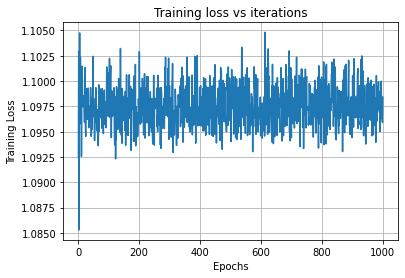

In [9]:
fig, ax = plt.subplots()
ax.plot(epochs, losses)

ax.set(xlabel='Epochs', ylabel='Training Loss',
       title='Training loss vs iterations')
ax.grid()

fig.savefig("test.png")
plt.show()

plt.close()

# 5 Performance Reporting